In [98]:
import heapq
import random

import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

# General setup code

In [99]:
#for small speedups we assume that v->j implies v <= j
class Poset:
    def __init__(self, num_nodes):
        self.num_nodes = num_nodes
        self._transitive_closure = [[(x==y) for y in range(num_nodes)] for x in range(num_nodes)]
        self.paths = []


    def insert(self, new_from_node, new_to_node):
        for from_node in range(self.num_nodes):
             for to_node in range(self.num_nodes):
                if self._transitive_closure[from_node][to_node]: continue
                self._transitive_closure[from_node][to_node] = (self._transitive_closure[from_node][new_from_node] 
                                                                    and self._transitive_closure[new_to_node][to_node])


    def insert_path(self, path):
        self.paths.append(path)
        for new_from_node, new_to_node in zip(path[:-1], path[1:]):
            self.insert(new_from_node, new_to_node)
    

    def is_antichain(self, path):
        #print(f"Candidate antichain: {path}")
        for from_node in path:
            #print(f"From node: {from_node}")
            for to_node in [node for node in path if node != from_node]:
                #print(f"To node: {to_node}")
                if self.are_comparable(from_node, to_node): return False
        return True


    def are_comparable(self, from_node, to_node):
        result =  self._transitive_closure[from_node][to_node]
        #print(f"{from_node} and {to_node} comparable: {result}")

        return result


# Greedy Packing

In [100]:
def greedy_pack(num_nodes, antichains):
    poset = Poset(num_nodes)
    heapq.heapify(antichains)
    #print(f"Initial antichains: {antichains}")
    while antichains:
        #print("---")
        smallest_antichain = heapq.heappop(antichains)
        #print(f"Adding: {smallest_antichain}")
        poset.insert_path(smallest_antichain)
        #print(f"Antichains after pop: {antichains}")
        antichains = [antichain for antichain in antichains if poset.is_antichain(antichain)]
        #print(f"Remaining antichains: {antichains}\n---")
        heapq.heapify(antichains)

    return poset.paths

# Random Packing

In [101]:
def random_pack(num_nodes, antichains):
    poset = Poset(num_nodes)
    #print(f"Initial antichains: {antichains}")
    while antichains:
        #print("---")
        smallest_antichain = antichains.pop(random.randrange(len(antichains)))
        #print(f"Adding: {smallest_antichain}")
        poset.insert_path(smallest_antichain)
        #print(f"Antichains after pop: {antichains}")
        antichains = [antichain for antichain in antichains if poset.is_antichain(antichain)]
        #print(f"Remaining antichains: {antichains}\n---")

    return poset.paths

# Layered graph setup code

In [102]:
# NUM_LAYERS = 3
# LAYER_WIDTH = 3
NUM_LAYERS = 4
STRETCH = 4
LAYER_WIDTH = (NUM_LAYERS - 2)* STRETCH
NUM_NODES = NUM_LAYERS * LAYER_WIDTH

def gen_layered_antichains(num_layers: int, layer_width):
    antichains = []
    cur_path = []
    def _gen_layered_antichains(cur_layer):
        nonlocal cur_path
        if cur_layer == num_layers:
            antichains.append(cur_path.copy())
            return
        
        cur_layer_start = cur_layer * layer_width
        for node in range(cur_layer_start, cur_layer_start + layer_width):
            cur_path.append(node)
            _gen_layered_antichains(cur_layer + 1)
            cur_path.pop()

    _gen_layered_antichains(0)
    return antichains


# Degree Counds & Other Queries

In [103]:
def paths_to_indegrees(paths, width):
    num_layers = len(paths[0])
    indegrees = [[0 for _ in range(width)] for _ in range(num_layers)]
    for path in paths:
        for vertex in path[1:]:
            layer = vertex // width
            offset = vertex % width

            indegrees[layer][offset] += 1
    
    return indegrees







# Layered path print code

In [104]:
def print_first_path_from_each_source(paths):
    new_paths = []
    seen = set()
    for path in paths:
        if path[0] in seen: continue
        seen.add(path[0])
        new_paths.append(path)
    print_layer_graph(new_paths)


def print_layer_graph_from_sources(paths, sources):
    new_paths = [path for path in paths if path[0] in sources]
    print_layer_graph(new_paths)
    

def print_layer_graph(paths):
    source_colors = ['tab:red','g','b','purple','orange','gold','maroon', 'pink', 'yellow', 'brown']

    G = nx.DiGraph()
    nodes = [(i, {"layer": (i // LAYER_WIDTH)}) for i in range(NUM_NODES)]
    G.add_nodes_from(nodes)
    for path in paths:
        source_color = source_colors[path[0] % len(source_colors)] 
        for from_node, to_node in zip(path[:-1], path[1:]):
            G.add_edge(from_node, to_node, color=source_color)

    pos = nx.multipartite_layout(G, subset_key="layer", align="horizontal")
    pos = {node: (-x,-y) for (node, (x,y)) in pos.items()}

    edges = G.edges()
    edge_colors = [G[u][v]['color'] for u,v in edges]

    nx.draw_networkx_nodes(G, pos=pos, node_color='black', node_size=50)
    nx.draw_networkx_edges(G, pos=pos, edge_color=edge_colors, node_size=50)
    plt.show()
    

In [105]:
graph = gen_layered_antichains(NUM_LAYERS, LAYER_WIDTH)

greedy_paths = greedy_pack(NUM_NODES, graph)


# random_paths = random_pack(NUM_NODES, graph)
# print(len(random_paths))
# print_layer_graph(random_paths)

24
[[0, 8, 16, 24], [0, 9, 17, 25], [0, 10, 18, 26], [0, 11, 19, 27], [0, 12, 20, 28], [0, 13, 21, 29], [0, 14, 22, 30], [0, 15, 23, 31], [1, 8, 17, 26], [1, 9, 18, 27], [1, 10, 19, 28], [1, 11, 20, 29], [1, 12, 21, 30], [1, 13, 22, 31], [2, 8, 18, 28], [2, 9, 19, 29], [2, 10, 20, 30], [2, 11, 21, 31], [3, 8, 19, 30], [3, 9, 20, 31], [4, 9, 21, 24], [5, 10, 16, 25], [6, 11, 16, 26], [7, 12, 16, 27]]


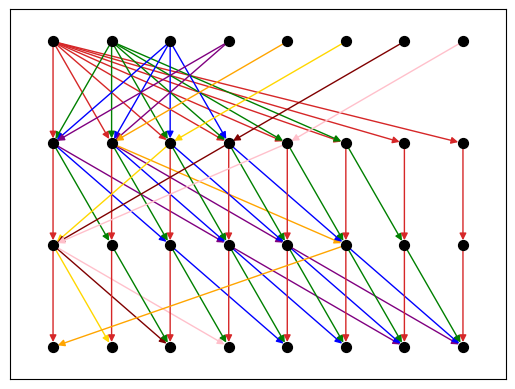

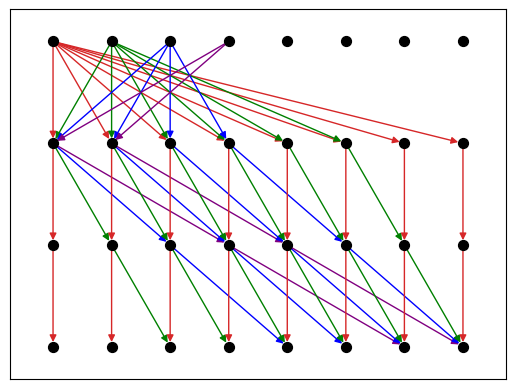

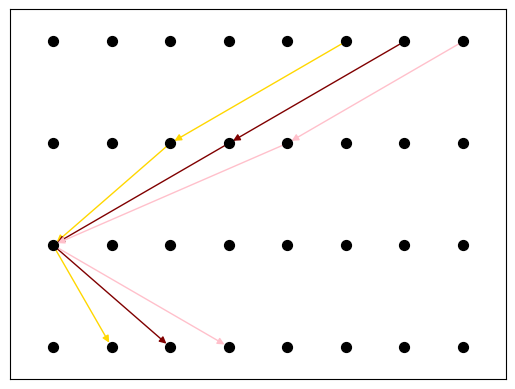

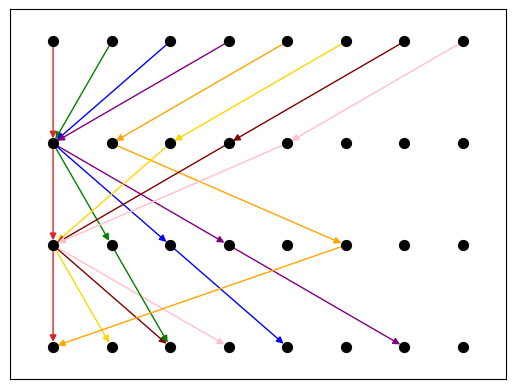

In [111]:
print(len(greedy_paths))
print(greedy_paths)

print_layer_graph(greedy_paths)
print_layer_graph_from_sources(greedy_paths, [i for i in range(STRETCH)])
print_layer_graph_from_sources(greedy_paths, [i for i in range(STRETCH + 1, LAYER_WIDTH)])
print_first_path_from_each_source(greedy_paths)

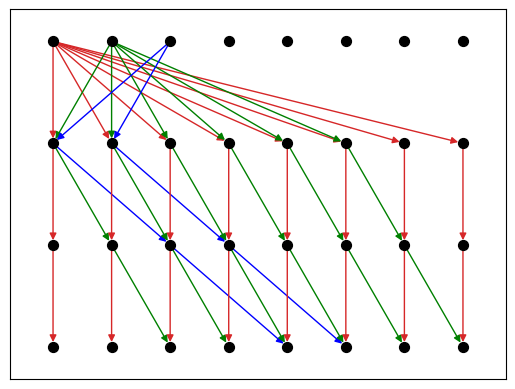

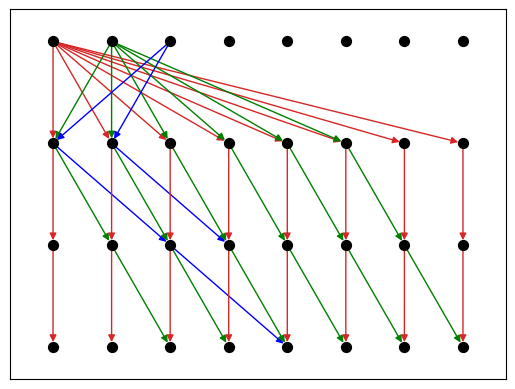

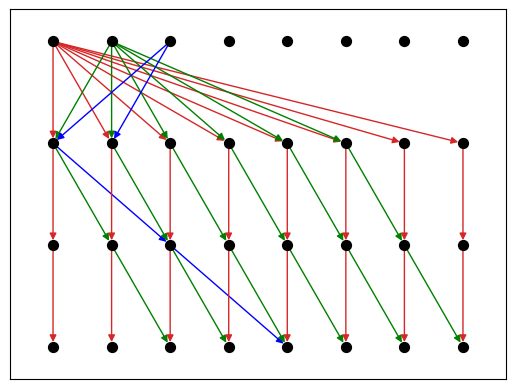

In [110]:
indegrees = paths_to_indegrees(greedy_paths, LAYER_WIDTH)
for layer in indegrees:
    print(layer)

# Random Data Collection

In [108]:
def gen_data():
    records = []
    for i in range(100):
        random_paths = random_pack(NUM_NODES, graph)
        num_paths = len(random_paths)
        beats_greedy = num_paths >= 2*NUM_LAYERS
        record = {'NUM_LAYERS': NUM_LAYERS, 'NUM_PATHS': num_paths, 'PATHS': random_paths, 'BEATS_GREEDY': beats_greedy}
        records.append(record)
    df = pd.DataFrame.from_dict(records)
    df.to_csv("random_paths5.csv")
    df.head()